In [ ]:
#!pip install tensorflow==2.2

### 1. Imports 

In [1]:
%matplotlib inline
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
print(f'Using TensorFlow version: {tf.__version__}')

Using TensorFlow version: 2.2.0


### 2. Load Data

In [3]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train.shape

(50000, 32, 32, 3)

In [5]:
y_train.shape

(50000, 1)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
y_test.shape

(10000, 1)

### 3. Explore Data

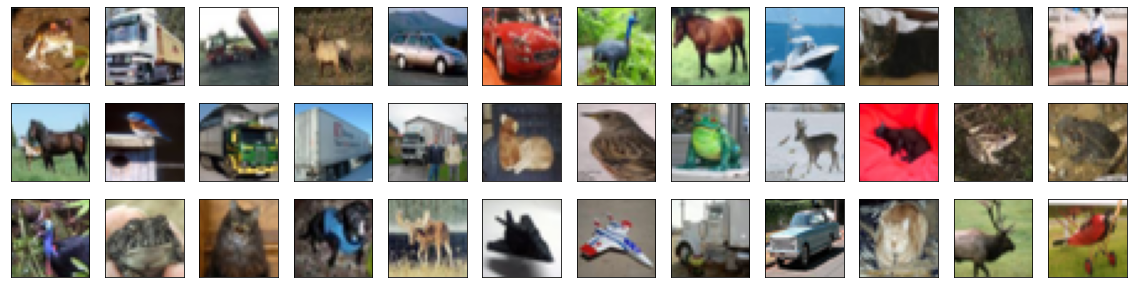

In [8]:
fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

### 4. Prep Data

#### 4.1 Rescale

In [9]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [10]:
X_train.shape

(50000, 32, 32, 3)

### 5. Split Data 

In [11]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [12]:
y_train.shape

(50000, 10)

In [13]:
y_test.shape

(10000, 10)

In [14]:
# break training set into training and validation sets
X_train, X_validation = X_train[5000:], X_train[:5000]
y_train, y_validation = y_train[5000:], y_train[:5000]

In [15]:
X_train.shape

(45000, 32, 32, 3)

In [16]:
X_validation.shape

(5000, 32, 32, 3)

### 6. Define Model Architecture

In [17]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

### 7. Compile Model

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 8. Train Model

In [19]:
checkpointer = ModelCheckpoint(filepath='cifar-best-model.hdf5', verbose=1, save_best_only=True)

In [20]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_validation, y_validation), 
                    callbacks=[checkpointer], 
                    verbose=2, 
                    shuffle=True)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.21325, saving model to cifar-best-model.hdf5
1407/1407 - 42s - loss: 1.5514 - accuracy: 0.4304 - val_loss: 1.2132 - val_accuracy: 0.5648
Epoch 2/10

Epoch 00002: val_loss improved from 1.21325 to 1.07059, saving model to cifar-best-model.hdf5
1407/1407 - 42s - loss: 1.2358 - accuracy: 0.5555 - val_loss: 1.0706 - val_accuracy: 0.6212
Epoch 3/10

Epoch 00003: val_loss improved from 1.07059 to 0.96938, saving model to cifar-best-model.hdf5
1407/1407 - 42s - loss: 1.1154 - accuracy: 0.6042 - val_loss: 0.9694 - val_accuracy: 0.6480
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.96938
1407/1407 - 42s - loss: 1.0305 - accuracy: 0.6365 - val_loss: 0.9760 - val_accuracy: 0.6618
Epoch 5/10

Epoch 00005: val_loss improved from 0.96938 to 0.87676, saving model to cifar-best-model.hdf5
1407/1407 - 42s - loss: 0.9617 - accuracy: 0.6619 - val_loss: 0.8768 - val_accuracy: 0.6938
Epoch 6/10

Epoch 00006: val_loss improved from 0.87676 t

### 9. Visualize Training

In [21]:
def plot_training_history(history):          
    hist = pd.DataFrame(history.history)          
    hist['epoch'] = history.epoch          
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Accuracy')          
    plt.plot(hist['epoch'], hist['accuracy'] * 100, label='Train Accuracy')          
    plt.plot(hist['epoch'], hist['val_accuracy'] * 100, label='Validation Accuracy')
    plt.ylim([0, 100])          
    plt.legend()  
    
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Loss')          
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')          
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.ylim([0,2])
    plt.legend()          
    plt.show()

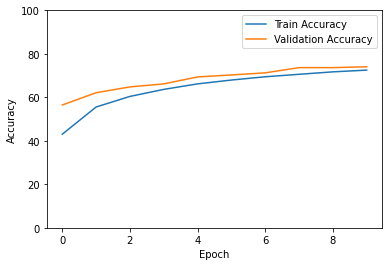

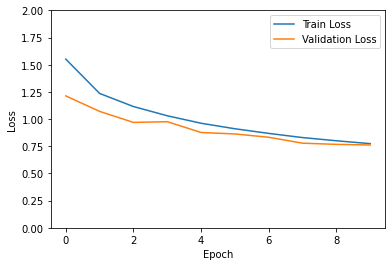

In [22]:
plot_training_history(history)

### 10. Evaluate Model

#### 10.1 Load the Best Model

In [24]:
model = load_model('cifar-best-model.hdf5')

In [25]:
result = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {result[1]}')

313/313 [==============================] - 3s 10ms/step - loss: 0.7793 - accuracy: 0.7285
Test accuracy: 0.7285000085830688


#### 10.2 Visualize Predictions

In [26]:
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
y_pred = model.predict(X_test)

In [28]:
y_pred[0]

array([2.3649159e-04, 3.3405825e-04, 2.1162985e-03, 6.8473583e-01,
       2.0124004e-03, 2.2163476e-01, 5.9739556e-02, 9.9730422e-04,
       2.7746398e-02, 4.4687485e-04], dtype=float32)

<p>Plot a random sample of test images with their expected (ground truth) and predicted labels.</p>

In [29]:
# pick 32 random image IDs from the total 10000 images 
random_ids = np.random.choice(10000, size=32, replace=False)

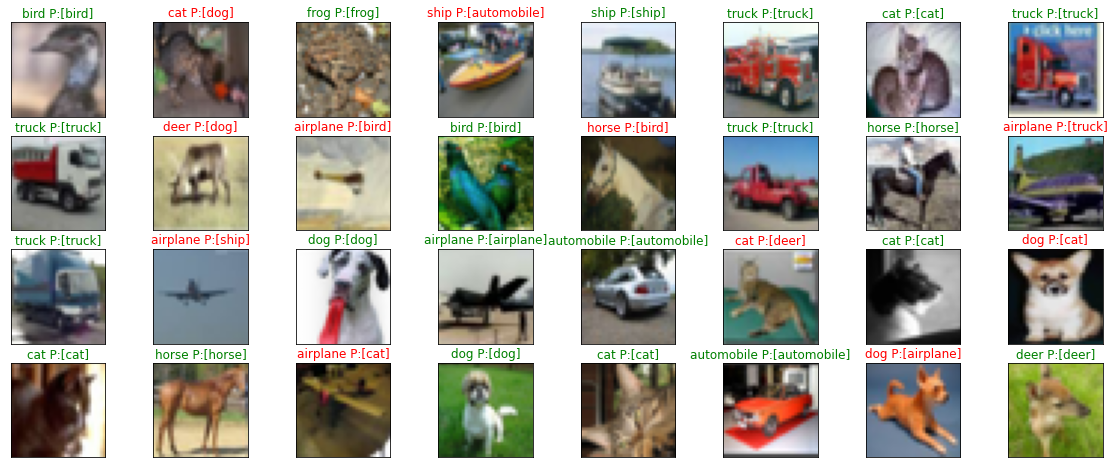

In [30]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(random_ids):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title('{} P:[{}]'.format(CIFAR10_LABELS[true_idx],
                                    CIFAR10_LABELS[pred_idx]),
                                    color=('green' if pred_idx == true_idx else 'red'))

### 11. Inference

In [60]:
import cv2

#### 11.1 Save Images for Inference

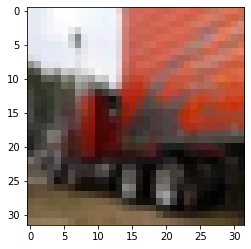

In [90]:
IMAGE_ID = 11
data = X_train[IMAGE_ID, :]
data = np.reshape(data, (32, 32, 3), order='F') # Fortran-like indexing order
plt.imshow(data)

In [91]:
data.shape

(32, 32, 3)

In [92]:
data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
cv2.imwrite('./DATA/CIFAR_10/truck.png', data)

True

#### 11.2 Read an Image

In [93]:
data = cv2.imread('./DATA/CIFAR_10/truck.png')
data = data.astype('float32')/255
data = data.reshape(1, 32, 32, 3)
data.shape

(1, 32, 32, 3)

#### 11.3 Load the best Model

In [100]:
model = load_model('cifar-best-model.hdf5')

#### 11.4 Run Prediction

In [95]:
y_pred = model.predict([data])

In [96]:
y_pred

array([[0.01854623, 0.00058567, 0.00378946, 0.44668463, 0.04518071,
        0.00132635, 0.00180322, 0.00514583, 0.4763616 , 0.00057625]],
      dtype=float32)

#### Predict using a raw input (Image) directly

In [ ]:
from sagemaker.predictor import json_deserializer
from IPython.display import Image, display
from numpy import argmax

def predict_bird_from_file(fn, verbose=True):
    with open(fn, 'rb') as img:
        f = img.read()
    x = bytearray(f)
    
    predictor.content_type = 'application/x-image'
    predictor.deserializer = json_deserializer
    predictor.serializer   = None
    
    results = predictor.predict(x)['predictions']

    predicted_class_idx = argmax(results)
    predicted_class = class_name_list[predicted_class_idx]
    confidence = results[0][predicted_class_idx]
    if verbose:
        display(Image(fn, height=HEIGHT, width=WIDTH))
        print('Class: {}, confidence: {:.2f}'.format(predicted_class, confidence))
    del img, x
    return predicted_class_idx, confidence

In [101]:
with open('./DATA/CIFAR_10/truck.png', 'rb') as img:
    f = img.read()
X = bytearray(f)
#predictor.content_type = 'application/x-image'
#predictor.deserializer = json_deserializer
#predictor.serializer   = None
model.predict(X)

ValueError: Failed to find data adapter that can handle input: <class 'bytearray'>, <class 'NoneType'>